In [ ]:
# Data Manipulating and Visualization
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
import random

# Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Operating System
import os

# Oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Machine Learning Algorithms
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier


# Performance metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
### Data Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
All_Data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print(All_Data.info(verbose=1))
All_Data['Class'].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

0.001727485630620034

In [3]:
X_Data = All_Data.drop(['Class'],axis=1)
Y_Data = All_Data['Class']

# 2. Data Exploration Analysis

## 2.1 Descriptive Statistics
- Apply the [pandas.DataFrame.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function
- Create a histogram plot for the winsorized data. Apply the [scipy.stats.mstats.winsorize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html) function for winsorization. 

In [4]:
def Describe_Feature(df,x_feature):
    ##### Basic statistic
    print(df[x_feature].describe().apply("{0:.3f}".format))
    print('0.1%:  '+str(df[x_feature].quantile(.001)))
    print('99.9%:  '+str(df[x_feature].quantile(.999)))
    
    ##### winsorization
    winsorized_data = winsorize(df[x_feature], limits=(0.001, 0.001))
    ##### Histgram
    sns.histplot(data=winsorized_data).set(xscale="log")
    plt.xlabel('Log Scale')
    plt.ylabel('Frequency (Count)')
    plt.title('Distribution of '+x_feature+' (log scaled)')
    plt.show()

count    284807.000
mean          0.002
std           0.042
min           0.000
25%           0.000
50%           0.000
75%           0.000
max           1.000
Name: Class, dtype: object
0.1%:  0.0
99.9%:  1.0


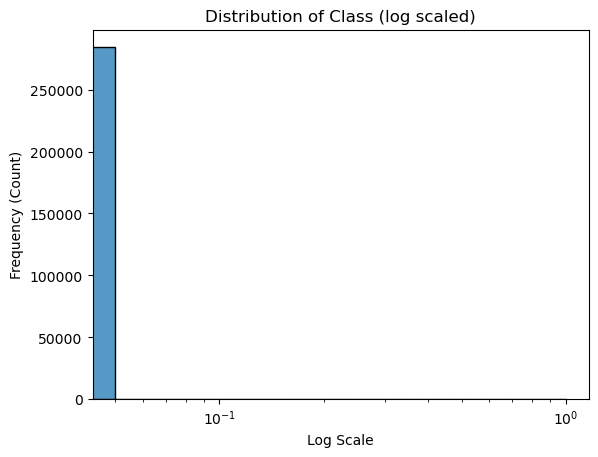

count    284807.000
mean      94813.860
std       47488.146
min           0.000
25%       54201.500
50%       84692.000
75%      139320.500
max      172792.000
Name: Time, dtype: object
0.1%:  204.0
99.9%:  172522.19400000002


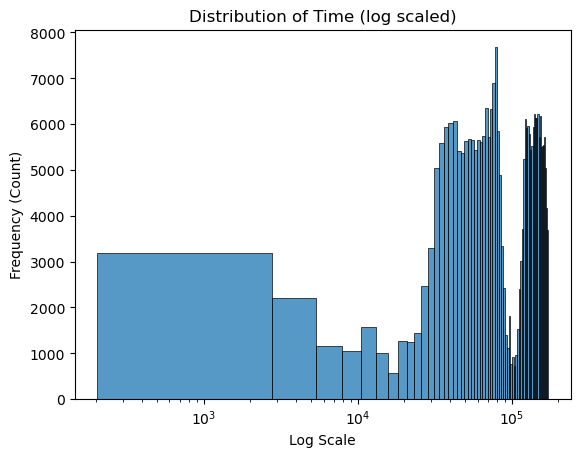

count    284807.000
mean         88.350
std         250.120
min           0.000
25%           5.600
50%          22.000
75%          77.165
max       25691.160
Name: Amount, dtype: object
0.1%:  0.0
99.9%:  3000.0


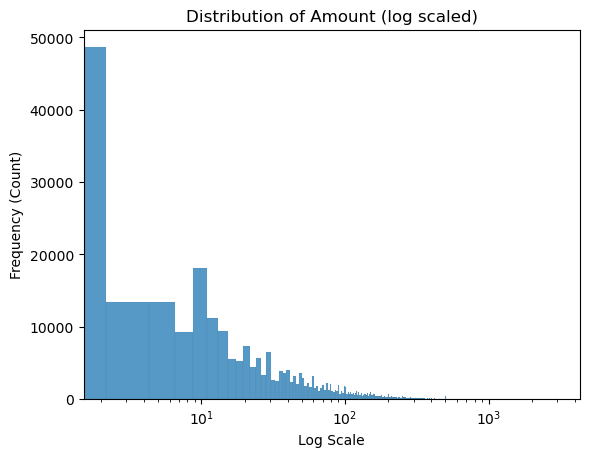

count    284807.000
mean         -0.000
std           0.999
min         -18.684
25%          -0.406
50%           0.140
75%           0.618
max           7.848
Name: V12, dtype: object
0.1%:  -5.702560014251391
99.9%:  2.7395009847052747


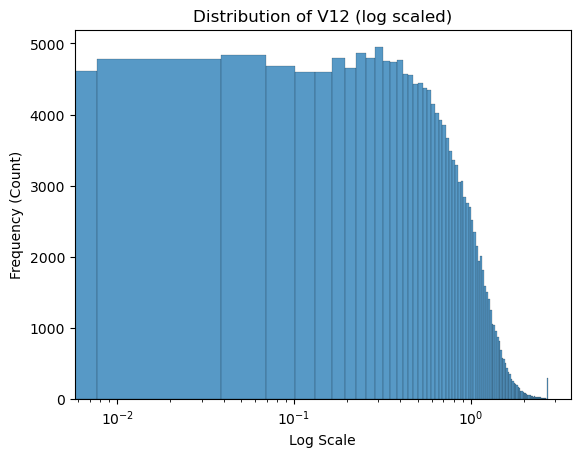

In [5]:
Describe_Feature(df=All_Data, x_feature='Class')
Describe_Feature(df=All_Data, x_feature='Time')
Describe_Feature(df=All_Data, x_feature='Amount')
Describe_Feature(df=All_Data, x_feature='V12')

## 2.2 Univariate Analysis
### (1) Outlier Detection

**decile_analysis()**
- Divide the df into *n_group* (a parameter) groups, based on the value of x_feature. 
- Calculate the mean of y_feature in each group. 
- Use [cut (ensure equal range)](https://pandas.pydata.org/docs/reference/api/pandas.cut.html)  or [qcut (ensure equal group size)](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) 

In [6]:
def decile_analysis(df,x_feature,y_feature,n_group,binning_method,Generate_plot):
    df_now = df.copy().sort_values(x_feature)
    ##### 'cut' : different bin size (could be empty), same bin widths. 
    ##### 'qcut': same bin size, different bin widths. 
    if binning_method == 'cut':
        df_now['group'] = pd.cut(df_now[x_feature], n_group, labels=False)
    if binning_method == 'qcut':
        df_now['group'] = pd.qcut(df_now[x_feature], n_group, labels=False)
    grouped_df = df_now.groupby('group').aggregate(count  = pd.NamedAgg(column=x_feature,aggfunc='count'),
                                                   x_min  = pd.NamedAgg(column=x_feature,aggfunc='min'),
                                                   x_max  = pd.NamedAgg(column=x_feature,aggfunc='max'),
                                                   x_mean = pd.NamedAgg(column=x_feature,aggfunc='mean'),
                                                   y_mean = pd.NamedAgg(column=y_feature,aggfunc='mean')).reset_index()
    if Generate_plot==True:
        plt.scatter(grouped_df['x_mean'], grouped_df['y_mean'])
        plt.xlabel(x_feature)
        plt.ylabel(y_feature)
        plt.title('Mean of '+y_feature +' in bins created based on '+x_feature)
        plt.show()
    
    return grouped_df

**detect_outliers_bin()**
- Detect "outlier" bin, in which the relationship between X and Y is significantly different from those in other bins (i.e., |z-score| is larger than 2.5). 
- Using the output of **decile_analysis()** as input.

In [7]:
def detect_outliers_bin(data, threshold=2.5):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = [(x - mean) / std for x in data]
    return np.where(np.abs(z_scores) > threshold)[0]

The codes below create a decile analysis for each feature, and finds if there exists points that are significantly different from other points.

In [8]:
columns_list           = All_Data.columns.tolist()
columns_list           = [item for item in columns_list if item != "Class"]

detect_outliers_result = pd.DataFrame({'Features': columns_list,'Outlier': [None] * len(columns_list)})
Decile_Results         = {}

for i in range(len(columns_list)):
    feature = columns_list[i]
    #print(feature)
    table = decile_analysis(df=All_Data,x_feature=feature,y_feature="Class",
                            n_group=20,binning_method='qcut',Generate_plot=False)
    outlier_indices = detect_outliers_bin(table['y_mean'])
    detect_outliers_result.loc[i,'Outlier'] = outlier_indices
    
    ##### Save the tables in a dict for future use
    Decile_Results[feature] = table

print(detect_outliers_result[detect_outliers_result['Outlier'].apply(lambda x: len(x) > 0)])

   Features  Outlier
0      Time     [10]
1        V1      [0]
2        V2     [19]
3        V3      [0]
4        V4     [19]
5        V5      [0]
6        V6      [0]
7        V7      [0]
8        V8     [19]
9        V9      [0]
10      V10      [0]
11      V11     [19]
12      V12      [0]
14      V14      [0]
16      V16      [0]
17      V17      [0]
18      V18      [0]
19      V19     [19]
20      V20     [19]
21      V21     [19]
22      V22     [19]
23      V23  [0, 19]
25      V25     [19]
26      V26     [17]
27      V27     [19]
28      V28     [19]
29   Amount      [1]


The table above shows the index of "outliers" in the scatter plots for each X and y. For example,
- the 11th point in the "Time vs Class" plot is considered to be an "outlier".
- the 1st and 20th points in the "V23 vs Class" plot are considered to be an "outlier".

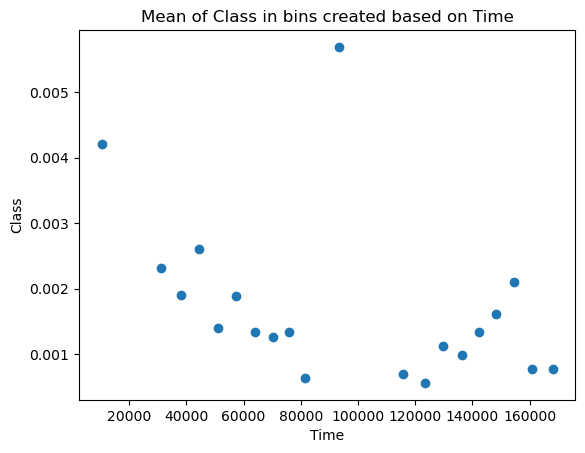

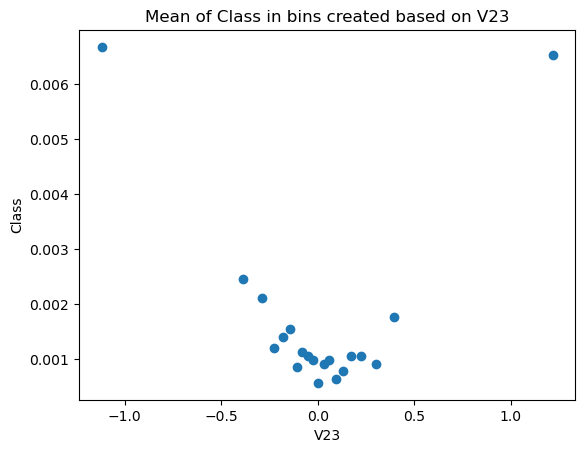

In [9]:
_ = decile_analysis(df=All_Data,x_feature='Time',y_feature="Class",n_group=20,binning_method='qcut',Generate_plot=True)
_ = decile_analysis(df=All_Data,x_feature='V23',y_feature="Class",n_group=20,binning_method='qcut',Generate_plot=True)

### (2) Regression Analysis
#### Codes below build a Simple Linear Regression model between X and Y, with and without the "outlier" points.
#### The LM(Linear Regression Model) is specified as "Y_mean = Intercept + beta * X_mean". 
#### The p-value of the coefficient beta is of particular interest.

In [10]:
simple_lm_result = detect_outliers_result.copy()
for i in range(len(columns_list)):
    feature = columns_list[i]
    table = decile_analysis(df=All_Data,x_feature=feature,y_feature="Class",
                            n_group=20,binning_method='qcut',Generate_plot=False)
    
    outlier_indices = detect_outliers_bin(table['y_mean'])

    ### Use the scaler to obtain standarized coefficients (does not affect p-values)
    scaler = StandardScaler()
    ### LM with all points
    X = table[['x_mean']].copy()
    X['x_mean'] = scaler.fit_transform(X)
    y = table['y_mean']
    X = sm.add_constant(X)
    model_with = sm.OLS(y, X)
    results = model_with.fit()
    coefficients = {param: coef for param, coef in zip(results.params.index, results.params)}
    p_values = {param: p_value for param, p_value in zip(results.params.index, results.pvalues)}
    simple_lm_result.loc[i,'N_withOutlier']    = len(X)
    simple_lm_result.loc[i,'Coef_withOutlier'] = round(coefficients['x_mean'],3)
    simple_lm_result.loc[i,'p_withOutlier']    = round(p_values['x_mean'],3)
    
    ### LM without outlier points
    if len(outlier_indices) > 0:
        table_2 = table.drop(outlier_indices)
    else:
        table_2 = table.copy()
    X = table_2[['x_mean']].copy()
    scaler = StandardScaler()
    X['x_mean'] = scaler.fit_transform(X)
    y = table_2['y_mean']
    X = sm.add_constant(X)
    model_without = sm.OLS(y, X)
    results = model_without.fit()
    coefficients = {param: coef for param, coef in zip(results.params.index, results.params)}
    p_values = {param: p_value for param, p_value in zip(results.params.index, results.pvalues)}
    simple_lm_result.loc[i,'N_withoutOutlier']    = len(X)
    simple_lm_result.loc[i,'Coef_withoutOutlier'] = round(coefficients['x_mean'],3)
    simple_lm_result.loc[i,'p_withoutOutlier']    = round(p_values['x_mean'],3)
    
simple_lm_result.head(15)

,Features,Outlier,N_withOutlier,Coef_withOutlier,p_withOutlier,N_withoutOutlier,Coef_withoutOutlier,p_withoutOutlier
0,Time,[10],20.0,-0.001,0.062,19.0,-0.001,0.005
1,V1,[0],20.0,-0.003,0.000,19.0,-0.001,0.002
2,V2,[19],20.0,0.002,0.016,19.0,0.000,0.261
3,V3,[0],20.0,-0.003,0.003,19.0,-0.000,0.000
4,V4,[19],20.0,0.004,0.001,19.0,0.001,0.006
5,V5,[0],20.0,-0.002,0.028,19.0,0.000,0.294
6,V6,[0],20.0,-0.001,0.086,19.0,-0.000,0.153
7,V7,[0],20.0,-0.003,0.007,19.0,0.000,0.331
8,V8,[19],20.0,0.001,0.311,19.0,-0.001,0.003
9,V9,[0],20.0,-0.002,0.009,19.0,-0.000,0.003


- Some features (e.g. Time, V1) have a significant linear relationship with the "Class", and this relationship is not solely caused by certain outliers. 
- Some features (e.g. V2, V3) show a clear linear relationship with the "Class", and this relationship may be casued by certain specific observations, because the coefficient is no longer significant after removing the "outlier" points.  
- Additionally, there are some features (e.g. V13) that do not exhibit a clear linear relationship with the "Class".
- Note that here we are only considering linear relationships and cannot rule out the possibility of non-linear relationships. For example, V13 exhibits a non-linear relationship with "Class".

## 2.3 Correlation Analysis

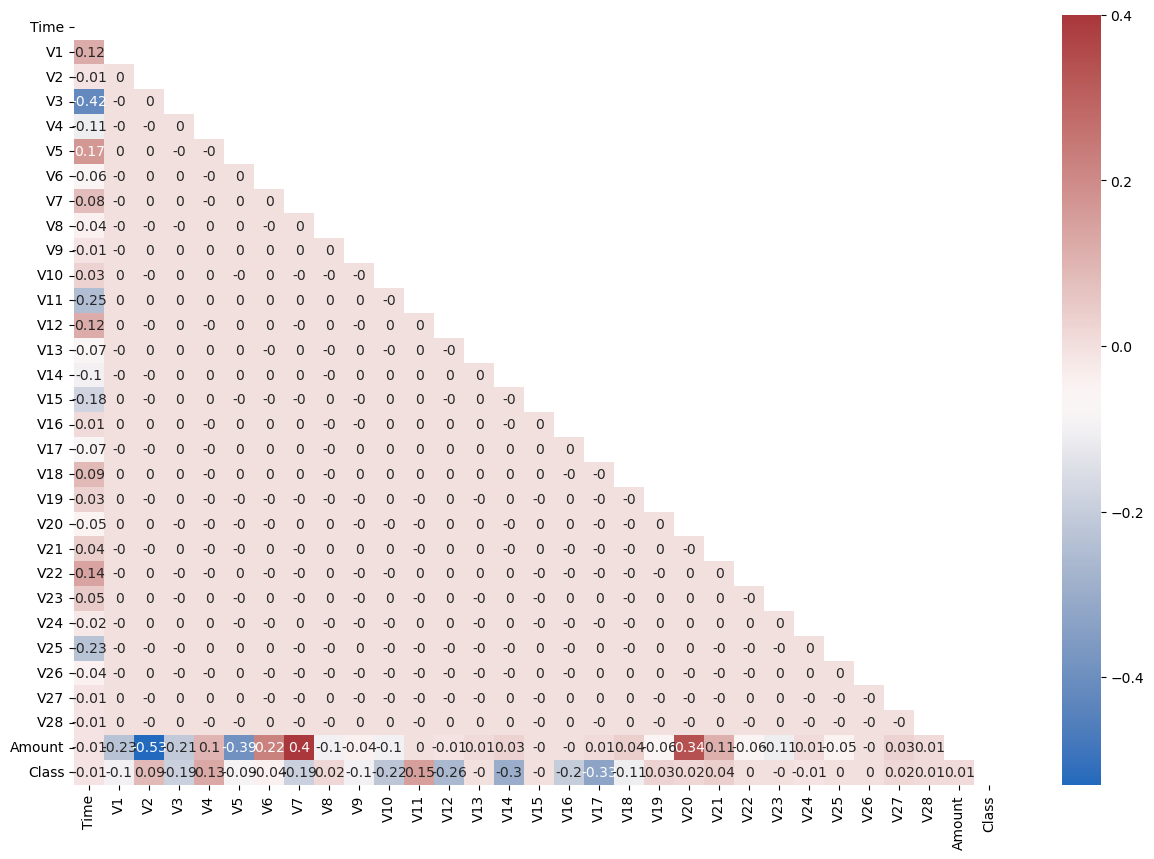

In [11]:
correlation_matrix = All_Data.corr().round(2)
mask               = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(15, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap="vlag", mask=mask)
plt.show()

# 3. Oversampling
The actual bad rate is very low in this data. 

In [12]:
print('Actual Bad Rate')
Y_Data.mean() 

Actual Bad Rate


0.001727485630620034

A preparation for conducting oversampling is to divide the original data into two parts: 
- 70% training data (x_train, y_train) - The training data will be further divided into a training set (x1,y1) and a validation set (x2,y2) in some gradient boosting model, where early stopping is applied.
- 30% testing data (x_test, y_test) - Actually this can be considered as a holdout data in this oversampling analysis. In the end, the testing performance is calculated using this raw dataset without any oversampling. 
- [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) is applied.  

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X_Data, 
                                                    Y_Data, 
                                                    test_size=0.3, 
                                                    random_state=42)

print('All')
print("Shape of X_Data: "+ str(X_Data.shape))
print("Shape of Y_Data: "+ str(X_Data.shape))
print("Bad Rate: "+ str(Y_Data.mean().round(6)))
print(Y_Data.value_counts())
print('Train')
print("Shape of X_Data: "+ str(X_train.shape))
print("Shape of Y_Data: "+ str(Y_train.shape))
print("Bad Rate: "+ str(Y_train.mean().round(6)))
print(Y_train.value_counts())
print('Test')
print("Shape of X_Data: "+ str(X_test.shape))
print("Shape of Y_Data: "+ str(Y_test.shape))
print("Bad Rate: "+ str(Y_test.mean().round(6)))
print(Y_test.value_counts())

All
Shape of X_Data: (284807, 30)
Shape of Y_Data: (284807, 30)
Bad Rate: 0.001727
0    284315
1       492
Name: Class, dtype: int64
Train
Shape of X_Data: (199364, 30)
Shape of Y_Data: (199364,)
Bad Rate: 0.001786
0    199008
1       356
Name: Class, dtype: int64
Test
Shape of X_Data: (85443, 30)
Shape of Y_Data: (85443,)
Bad Rate: 0.001592
0    85307
1      136
Name: Class, dtype: int64


## 3.1 - Create New Sample using different over-sampling methods
### [The reference of the methods discussed in this notebook](https://imbalanced-learn.org/stable/over_sampling.html)

### 3.1.1 - Naive random oversampling
Over-sample the minority class(es) by picking samples at random with replacement.**

In [14]:
X_rosampled, Y_rosampled = RandomOverSampler().fit_resample(X_train, Y_train)
Y_rosampled_temp         = Y_rosampled
All_shuffle = pd.concat([X_rosampled, Y_rosampled.rename("Class")], axis=1)
All_shuffle = All_shuffle.sample(frac=1).reset_index(drop=True)
X_rosampled = All_shuffle.drop(['Class'],axis=1)
Y_rosampled = All_shuffle['Class']

print("Shape of X_Data: "+ str(X_rosampled.shape))
print("Shape of Y_Data: "+ str(Y_rosampled.shape))
print("Bad Rate: "+ str(Y_rosampled.mean().round(6)))
print(Y_rosampled.value_counts())

Shape of X_Data: (398016, 30)
Shape of Y_Data: (398016,)
Bad Rate: 0.5
0    199008
1    199008
Name: Class, dtype: int64


**Note that in the new oversampled data, the newly generated rows are all placed at the end, i.e., at the bottom (~50%) of the data, all 'y' values are equal to 1. This could potentially lead to misleading results in certain analyses, such as cross-validation. Therefore, here we perform a random shuffle on the oversampled data.**

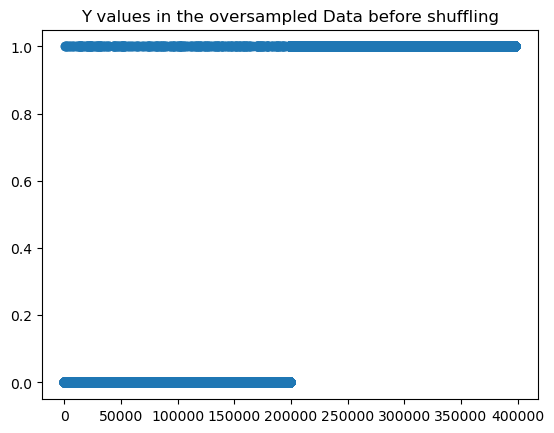

In [15]:
plt.scatter(Y_rosampled_temp.index, Y_rosampled_temp.values)
plt.title('Y values in the oversampled Data before shuffling')
plt.show()

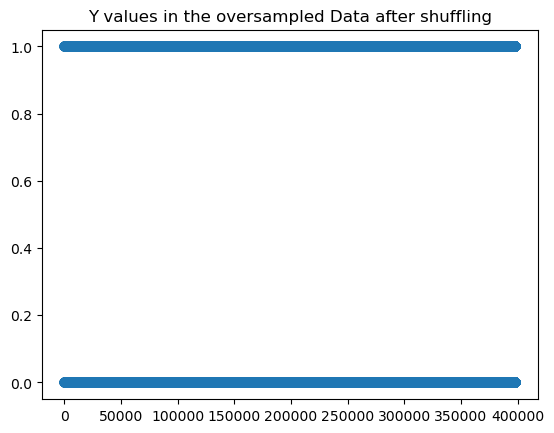

In [16]:
plt.scatter(Y_rosampled.index, Y_rosampled.values)
plt.title('Y values in the oversampled Data after shuffling')
plt.show()

### 3.1.2 - SMOTE
Synthetic Minority Oversampling Technique (SMOTE) is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

At first the total no. of oversampling observations, N is set up. Generally, it is selected such that the binary class distribution is 1:1. But that could be tuned down based on need. Then the iteration starts by first selecting a positive class instance at random. Next, the KNN’s (by default 5) for that instance is obtained. At last, N of these K instances is chosen to interpolate new synthetic instances. To do that, using any distance metric the difference in distance between the feature vector and its neighbors is calculated. Now, this difference is multiplied by any random value in (0,1] and is added to the previous feature vector. This is pictorially represented below:

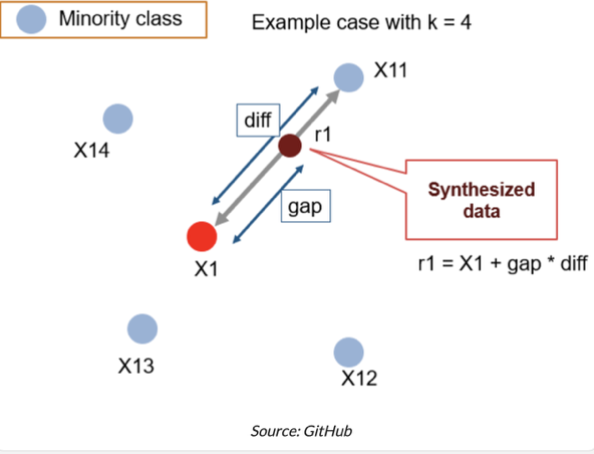

### [Reference](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#h-adasyn-adaptive-synthetic-sampling-approach)

In [17]:
X_SMOTE, Y_SMOTE = SMOTE().fit_resample(X_train, Y_train)
##### Shuffling
All_shuffle = pd.concat([X_SMOTE, Y_SMOTE.rename("Class")], axis=1)
All_shuffle = All_shuffle.sample(frac=1).reset_index(drop=True)
X_SMOTE     = All_shuffle.drop(['Class'],axis=1)
Y_SMOTE     = All_shuffle['Class']

print("Shape of X_Data: "+ str(X_SMOTE.shape))
print("Shape of Y_Data: "+ str(Y_SMOTE.shape))
print("Bad Rate: "+ str(Y_SMOTE.mean().round(6)))
print(Y_SMOTE.value_counts())

Shape of X_Data: (398016, 30)
Shape of Y_Data: (398016,)
Bad Rate: 0.5
0    199008
1    199008
Name: Class, dtype: int64


### 3.1.3 - ADASYN
ADASYN is a generalized form of the SMOTE algorithm. This algorithm also aims to oversample the minority class by generating synthetic instances for it. But the difference here is it considers the density distribution, ri which decides the no. of synthetic instances generated for samples which difficult to learn. Due to this, it helps in adaptively changing the decision boundaries based on the samples difficult to learn. This is the major difference compared to SMOTE. The below-given diagram represents the above procedure:

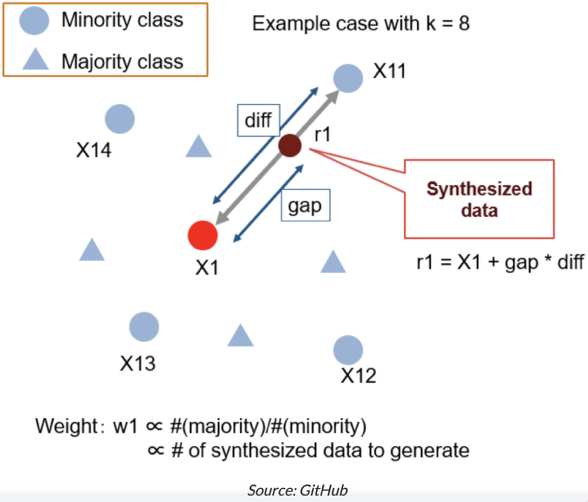

### [Reference](https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#h-adasyn-adaptive-synthetic-sampling-approach)

In [18]:
X_ADASYN, Y_ADASYN = ADASYN().fit_resample(X_train, Y_train)

##### Shuffling
All_shuffle = pd.concat([X_ADASYN, Y_ADASYN.rename("Class")], axis=1)
All_shuffle = All_shuffle.sample(frac=1).reset_index(drop=True)
X_ADASYN     = All_shuffle.drop(['Class'],axis=1)
Y_ADASYN     = All_shuffle['Class']

print("Shape of X_Data: "+ str(X_ADASYN.shape))
print("Shape of Y_Data: "+ str(Y_ADASYN.shape))
print("Bad Rate: "+ str(Y_ADASYN.mean().round(6)))
print(Y_ADASYN.value_counts())

Shape of X_Data: (397968, 30)
Shape of Y_Data: (397968,)
Bad Rate: 0.49994
0    199008
1    198960
Name: Class, dtype: int64


## 3.2 - Build Quick Models

### Conduct data partitioning for 4 sets of datasets
#### 1. Raw Data (unbalanced)
#### 2. Naive random oversampling
#### 3. SMOTE 
#### 4. ADASYN

In [19]:
x1_raw, x2_raw, y1_raw, y2_raw                         = train_test_split(X_train,Y_train,
                                                                          test_size = 0.3)
x1_rosampled, x2_rosampled, y1_rosampled, y2_rosampled = train_test_split(X_rosampled,Y_rosampled,
                                                                          test_size = 0.3)
x1_SMOTE, x2_SMOTE, y1_SMOTE, y2_SMOTE                 = train_test_split(X_SMOTE,Y_SMOTE,
                                                                          test_size = 0.3)
x1_ADASYN, x2_ADASYN, y1_ADASYN, y2_ADASYN             = train_test_split(X_ADASYN,Y_ADASYN,
                                                                          test_size = 0.3)

### LGBMClassifier
##### https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

In [20]:
def LGBMClassifier_oversample_analysis(oversample):
    print()
    print(oversample)
    
    result = {}
    
    lgb_model = lgb.LGBMClassifier()
    
    if oversample == 'raw':
        x1=x1_raw; y1=y1_raw; x2=x2_raw; y2=y2_raw
    elif oversample == 'rosampled':
        x1=x1_rosampled; y1=y1_rosampled; x2=x2_rosampled; y2=y2_rosampled
    elif oversample == 'SMOTE':
        x1=x1_SMOTE; y1=y1_SMOTE; x2=x2_SMOTE; y2=y2_SMOTE
    elif oversample == 'ADASYN':
        x1=x1_ADASYN; y1=y1_ADASYN; x2=x2_ADASYN; y2=y2_ADASYN
                  
    lgb_model.fit(X = x1, y = y1,
                  eval_set  = [(x1, y1), (x2, y2)],
                  callbacks = [lgb.early_stopping(50),lgb.log_evaluation(0)]) 
    
    result['N_estimator']       = lgb_model.best_iteration_
    result['Valid_score']       = lgb_model.best_score_['valid_1']['binary_logloss']
    test_pred                   = lgb_model.predict(X_test)
    result['Holdout_mean_pred'] = test_pred.mean()
    result['Holdout_score']     = log_loss(Y_test,test_pred)
    
    return result

In [21]:
LGBM_raw       = LGBMClassifier_oversample_analysis(oversample='raw')
LGBM_rosampled = LGBMClassifier_oversample_analysis(oversample='rosampled')
LGBM_SMOTE     = LGBMClassifier_oversample_analysis(oversample='SMOTE')
LGBM_ADASYN    = LGBMClassifier_oversample_analysis(oversample='ADASYN')
LGBM_Result    = pd.DataFrame.from_records([LGBM_raw, LGBM_rosampled,LGBM_SMOTE,LGBM_ADASYN])
LGBM_Result.insert(loc=0, column='OverSample', value=['Raw','Random','SMOTE','ADASYN'])
LGBM_Result


raw
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0124846	valid_1's binary_logloss: 0.0182863

rosampled
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.000485423	valid_1's binary_logloss: 0.000996194

SMOTE
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.00248086	valid_1's binary_logloss: 0.00424688

ADASYN
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.00253489	valid_1's binary_logloss: 0.00428352


,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,1,0.018286,0.002493,0.045981
1,Random,100,0.000996,0.001697,0.020670
2,SMOTE,100,0.004247,0.002259,0.038388
3,ADASYN,100,0.004284,0.002399,0.041763


### XGB
##### https://xgboost.readthedocs.io/en/stable/parameter.html#

In [22]:
def XGBRegressor_oversample_analysis(oversample):
    result = {}
    
    ##### specify the metrics="logloss"
    xgb_model = xgb.XGBRegressor(eval_metric='logloss',early_stopping_rounds=20)
    
    if oversample == 'raw':
        x1=x1_raw; y1=y1_raw; x2=x2_raw; y2=y2_raw
    elif oversample == 'rosampled':
        x1=x1_rosampled; y1=y1_rosampled; x2=x2_rosampled; y2=y2_rosampled
    elif oversample == 'SMOTE':
        x1=x1_SMOTE; y1=y1_SMOTE; x2=x2_SMOTE; y2=y2_SMOTE
    elif oversample == 'ADASYN':
        x1=x1_ADASYN; y1=y1_ADASYN; x2=x2_ADASYN; y2=y2_ADASYN
                  
    xgb_model.fit(X = x1, y = y1,
                  eval_set  = [(x1, y1), (x2, y2)],
                  verbose=50) 
 
    result['N_estimator']       = xgb_model.best_iteration
    result['Valid_score']       = xgb_model.best_score
    test_pred                   = xgb_model.predict(X_test)
    result['Holdout_mean_pred'] = test_pred.mean()
    result['Holdout_score']     = log_loss(Y_test,test_pred)
    
    return result

In [23]:
XGB_raw       = XGBRegressor_oversample_analysis(oversample='raw')
XGB_rosampled = XGBRegressor_oversample_analysis(oversample='rosampled')
XGB_SMOTE     = XGBRegressor_oversample_analysis(oversample='SMOTE')
XGB_ADASYN    = XGBRegressor_oversample_analysis(oversample='ADASYN')
XGB_Result    = pd.DataFrame.from_records([XGB_raw, XGB_rosampled,XGB_SMOTE,XGB_ADASYN])
XGB_Result.insert(loc=0, column='OverSample', value=['Raw','Random','SMOTE','ADASYN'])
XGB_Result

[0]	validation_0-logloss:0.43110	validation_1-logloss:0.43134
[38]	validation_0-logloss:0.00038	validation_1-logloss:0.00687
[0]	validation_0-logloss:0.45460	validation_1-logloss:0.45440
[50]	validation_0-logloss:0.00324	validation_1-logloss:0.00465
[99]	validation_0-logloss:0.00142	validation_1-logloss:0.00301
[0]	validation_0-logloss:0.44997	validation_1-logloss:0.45068
[50]	validation_0-logloss:0.00744	validation_1-logloss:0.01032
[99]	validation_0-logloss:0.00364	validation_1-logloss:0.00577
[0]	validation_0-logloss:0.45071	validation_1-logloss:0.45113
[50]	validation_0-logloss:0.00785	validation_1-logloss:0.01119
[99]	validation_0-logloss:0.00404	validation_1-logloss:0.00696


,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,18,0.005598,0.002229,0.002973
1,Random,97,0.003000,0.002853,0.014413
2,SMOTE,99,0.005770,0.005533,0.020009
3,ADASYN,99,0.006964,0.005924,0.021840


### Random Forest
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [24]:
def RandomForest_oversample_analysis(oversample):
    result = {}
    
    ##### specify the metrics="logloss"
    rf_model = RandomForestClassifier(criterion='log_loss',n_estimators=200)
    
    if oversample == 'raw':
        x1=x1_raw; y1=y1_raw; x2=x2_raw; y2=y2_raw
    elif oversample == 'rosampled':
        x1=x1_rosampled; y1=y1_rosampled; x2=x2_rosampled; y2=y2_rosampled
    elif oversample == 'SMOTE':
        x1=x1_SMOTE; y1=y1_SMOTE; x2=x2_SMOTE; y2=y2_SMOTE
    elif oversample == 'ADASYN':
        x1=x1_ADASYN; y1=y1_ADASYN; x2=x2_ADASYN; y2=y2_ADASYN
                  
    rf_model.fit(X = x1, y = y1)

    result['N_estimator']       = 200
    result['Valid_score']       = log_loss(y2,rf_model.predict(x2))
    result['Holdout_mean_pred'] = rf_model.predict(X_test).mean()
    result['Holdout_score']     = log_loss(Y_test,rf_model.predict(X_test))
    
    return result

In [25]:
RF_raw       = RandomForest_oversample_analysis(oversample='raw')
RF_rosampled = RandomForest_oversample_analysis(oversample='rosampled')
RF_SMOTE     = RandomForest_oversample_analysis(oversample='SMOTE')
RF_ADASYN    = RandomForest_oversample_analysis(oversample='ADASYN')
RF_Result    = pd.DataFrame.from_records([RF_raw, RF_rosampled,RF_SMOTE,RF_ADASYN])
RF_Result.insert(loc=0, column='OverSample', value=['Raw','Random','SMOTE','ADASYN'])
RF_Result

,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,200,0.022298,0.001346,0.013921
1,Random,200,0.001811,0.001440,0.013921
2,SMOTE,200,0.003019,0.001732,0.019405
3,ADASYN,200,0.003925,0.001802,0.021092


## 2.3 - A Summary of Oversampling

- Validation datasets are oversampled. Holdout datasets are not oversampled.
- In both LGBM and XGB, during the training, validation data is used in the early stopping algorithm. 
- However, in the case of Random Forest (rf), the validation data is not utilized during training, so it is similar to a holdout dataset.

**Note that this results are for the "quick models" where the default values are used for the hyperparameters. A discussion about hyperparameter tuning using oversampled data with different methods are [discussed in this notebook]().**

In [26]:
def plot_bar_results(df,title):
    df.plot.bar(x = 'OverSample', 
                y = ['Valid_score', 'Holdout_score'])
    plt.ylim(0, 0.05)
    plt.title(title)
    plt.legend()
    plt.show()

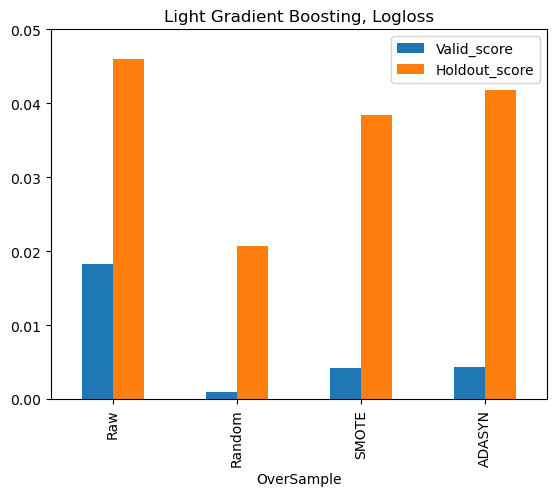

,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,1,0.018286,0.002493,0.045981
1,Random,100,0.000996,0.001697,0.020670
2,SMOTE,100,0.004247,0.002259,0.038388
3,ADASYN,100,0.004284,0.002399,0.041763


In [27]:
plot_bar_results(LGBM_Result,'Light Gradient Boosting, Logloss')
LGBM_Result

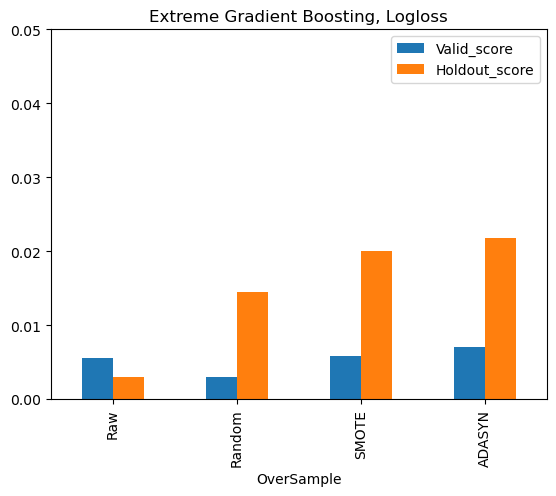

,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,18,0.005598,0.002229,0.002973
1,Random,97,0.003000,0.002853,0.014413
2,SMOTE,99,0.005770,0.005533,0.020009
3,ADASYN,99,0.006964,0.005924,0.021840


In [28]:
plot_bar_results(XGB_Result,'Extreme Gradient Boosting, Logloss')
XGB_Result

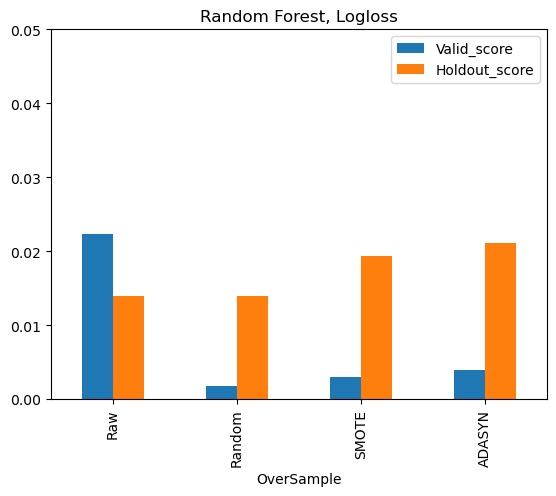

,OverSample,N_estimator,Valid_score,Holdout_mean_pred,Holdout_score
0,Raw,200,0.022298,0.001346,0.013921
1,Random,200,0.001811,0.001440,0.013921
2,SMOTE,200,0.003019,0.001732,0.019405
3,ADASYN,200,0.003925,0.001802,0.021092


In [29]:
plot_bar_results(RF_Result,'Random Forest, Logloss')
RF_Result